# Cride Oil Production Forecasting

**- In this case study, we will analyze and use historical oil production data, from 1992 to 2018, for a country to forecast its future production. We need to build a time series forecasting model using the AR, MA, ARMA, and ARIMA models in order to forecast oil production.**

In [1]:
# Libraries to do data manipulation
import numpy as np

import pandas as pd

# Library to do data visualization
import matplotlib.pyplot as plt

# Library to do time series decomposition
import statsmodels.api as sm

# Importing ADF test from statsmodels package
from statsmodels.tsa.stattools import adfuller

# Module to create ACF and PACF plots
from statsmodels.graphics import tsaplots

# Module to build AR, MA, ARMA, and ARIMA models
from statsmodels.tsa.arima.model import ARIMA

# Module to implement MSE and RSME during model evaluation
from sklearn.metrics import mean_squared_error

# Code for ignoring unnecessary warnings while executing some code  
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Downloads/Crude+Oil+Production+by+Country.csv")

In [3]:
data.head(5)

,Country,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,United States,7171,6847,6662,6560,6465,6451,6252,5881,5822,...,5349,5478,5654,6502.0,7467.0,8759.0,9431.0,8831.0,9352.0,10962.0
1,Saudi Arabia,8332,8198,8120,8231,8218,8362,8389,7833,8404,...,8250,8900,9458,9832.0,9693.0,9735.0,10168.0,10461.0,10134.0,10425.0
2,Russia,7632,6730,6135,5995,5850,5920,5854,6079,6479,...,9495,9694,9774,9922.0,10054.0,10107.0,10253.0,10551.0,10580.0,10759.0
3,Canada,1605,1679,1746,1805,1837,1922,1981,1907,1977,...,2579,2741,2901,3138.0,3325.0,3613.0,3677.0,3679.0,3977.0,4264.0
4,Iraq,425,512,553,560,579,1155,2150,2508,2571,...,2391,2399,2626,2983.0,3054.0,3368.0,4045.0,4444.0,4454.0,4613.0


- **This dataset has yearly crude oil production data for 222 countries starting from 1992 till 2018.** 
- **Since the frequency of this dataset is yearly, we will not get any seasonal patterns in this time series.** 
- **However, we can expect cyclicity in the data over multiple years.**


In [4]:
# Using loc and index = 0 to fetch the data for United States from the original dataset

united_states = data.loc[0]
united_states.head(5)

Country    United States
1992                7171
1993                6847
1994                6662
1995                6560
Name: 0, dtype: object

- **Since there are observations from 222 countries, i.e., we have 222 different time series. We will select only one time series (United States)  for forecasting purpose in this project.**


In [5]:
# Dropping the variable country (United States), as we only need the time and production information to build the model

united_states = pd.DataFrame(united_states).drop(['Country'])
united_states = united_states.reset_index()
united_states.head(5)

,index,0
0,1992,7171
1,1993,6847
2,1994,6662
3,1995,6560
4,1996,6465


In [6]:
# Creating DataFrame for United States oil production

# Fetching the two columns - YEAR and OIL PRODUCTION
united_states.columns = ['YEAR', 'OIL PRODUCTION']

# Converting the data type for variable OIL PRODUCTION to integer
united_states['OIL PRODUCTION'] = united_states['OIL PRODUCTION'].astype(int)

# Converting the YEAR column data type to datetime
united_states['YEAR'] = pd.to_datetime(united_states['YEAR'])

# Setting the variable YEAR as the index of this dataframe
united_states = united_states.set_index('YEAR')

# Checking the time series crude oil production data for United States
united_states.head()

,OIL PRODUCTION
YEAR,
1992-01-01,7171
1993-01-01,6847
1994-01-01,6662
1995-01-01,6560
1996-01-01,6465


**Visualizing the time series and decomposing it**

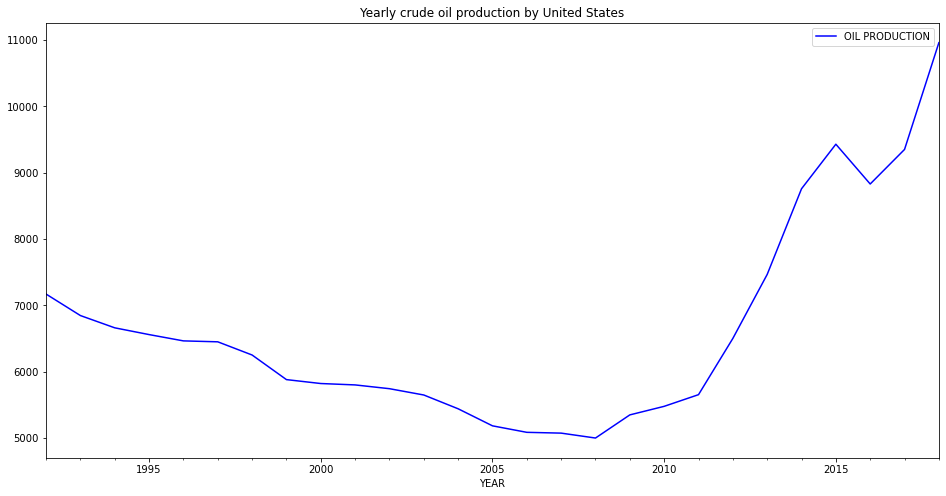

In [7]:
#Visualizing the time series and decomposing it

ax = united_states.plot(color = 'blue', figsize = (16, 8))

ax.set_title('Yearly crude oil production by United States')

plt.show()

**Observation:**

- The above plot shows that the oil production of United States was declining from the early 1990s to the mid 2000s but has been increasing almost constantly since then.
- The higher oil production can be due to increasing population and hence, increasing the demand for transportation and other needs.





**Decomposing our data into its various components, i.e., trend, seasonality, and white noise.** 

**- Since this is yearly frequency data, there would not be any seasonal patterns** 

In [8]:
# Using seasonal_decompose function to decompose the time series into its individual components

decomposition = sm.tsa.seasonal_decompose(united_states)

In [9]:
# Creating an empty dataframe to store the individual components
decomposed_data = pd.DataFrame()

# Extracting the trend component of time series
decomposed_data['trend'] = decomposition.trend

# Extracting the seasonal component of time series
decomposed_data['seasonal'] = decomposition.seasonal

# Extracting the white noise or residual component of time series
decomposed_data['random_noise'] = decomposition.resid

In [10]:
decomposed_data.head(5)

,trend,seasonal,random_noise
YEAR,,,
1992-01-01,7171.0,0.0,0.0
1993-01-01,6847.0,0.0,0.0
1994-01-01,6662.0,0.0,0.0
1995-01-01,6560.0,0.0,0.0
1996-01-01,6465.0,0.0,0.0


<AxesSubplot:xlabel='YEAR'>

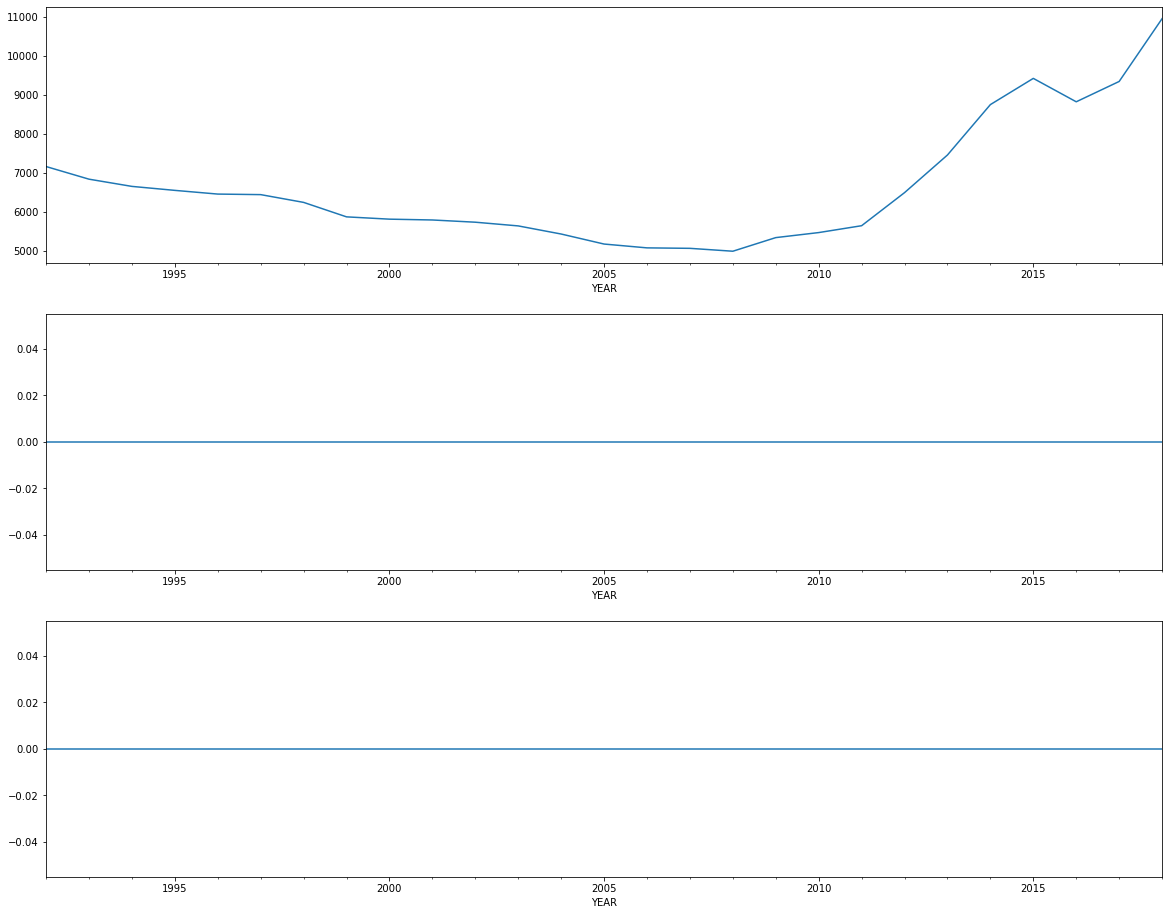

In [11]:
#Plotting the above three components in a single plot

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (20, 16))

decomposed_data['trend'].plot(ax = ax1)

decomposed_data['seasonal'].plot(ax = ax2)

decomposed_data['random_noise'].plot(ax = ax3)

**Observation:**

- As we can see from the above plot, the seasonal and residual components are zero, as this time series has a yearly frequency.

In [12]:
#split the time series dataset

# Using the first 20 years data as the training data
train_data = united_states.loc['1992-01-01' : '2012-01-01']

# Using the last 7 years data as the test data
test_data = united_states.loc['2012-01-01':]

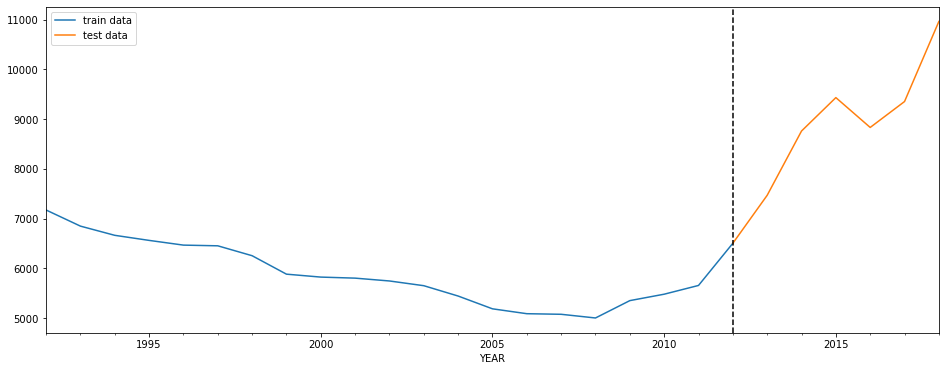

In [13]:
# Visualize the train and the test data in the same plot

# Creating a subplot space
fig, ax = plt.subplots(figsize = (16, 6))

# Plotting train data
train_data.plot(ax = ax)

# Plotting test data
test_data.plot(ax = ax)

# Adding the legends in sequential order
plt.legend(['train data', 'test data'])

# Showing the time which divides the original data into train and test
plt.axvline(x = '2012-01-01', color = 'black', linestyle = '--')

# Showing the plot
plt.show()

**Checking For Stationary**

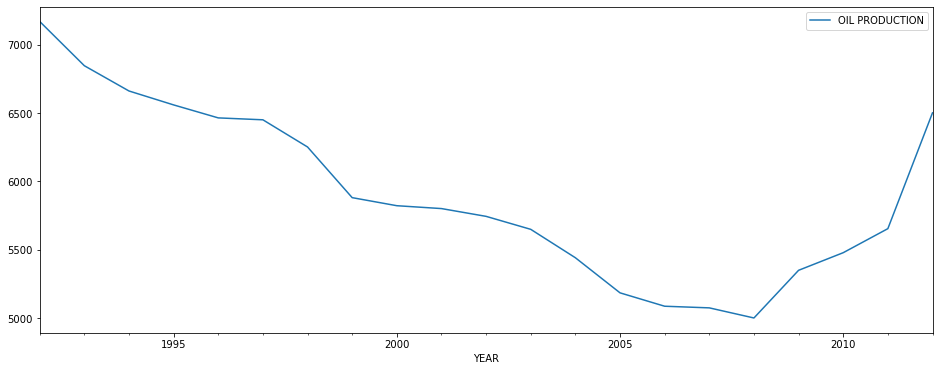

ADF Statistic: -0.5829098523091657
p-value: 0.8747971281795591


In [14]:
# Augmented Dicky-Fuller Test

# Implementing ADF test on the original time series data
result = adfuller(train_data['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

**Observation:**

- Here, the p-value is around 0.87, which is higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary.
- We can also see by visually inspecting the time series that its non-stationary.

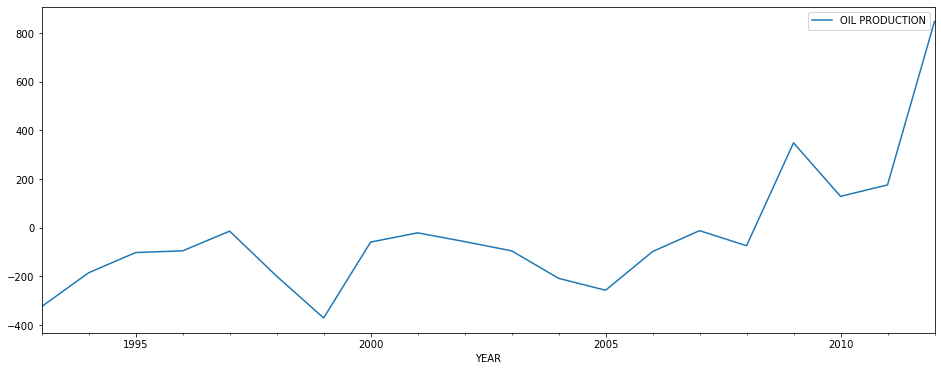

ADF Statistic: 1.575800707060063
p-value: 0.9977831288888278


In [15]:
# Taking the 1st order differencing of the timeseries
train_data_stationary = train_data.diff().dropna()

# Implementing ADF test on the first order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

**Observation:**

- Here, the p-value is around 0.99, which is again higher than 0.05. Again, we fail to reject the null hypothesis, and we can say the time series is non-stationary. 

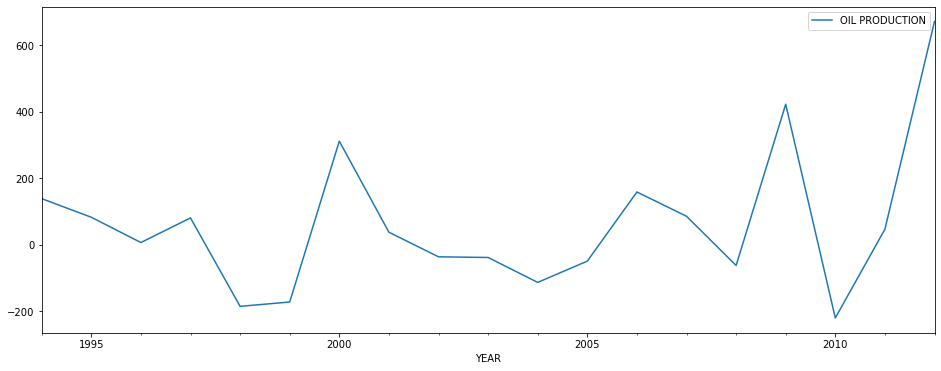

ADF Statistic: -1.5580506601256097
p-value: 0.5046243689112174


In [16]:
# Taking the 2nd order differencing of the time series
train_data_stationary = train_data.diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

**Observation:**

- Here, the p-value is around 0.50, which is again higher than 0.05. Hence, we fail to reject the null hypothesis, and we can say the time series is non-stationary.

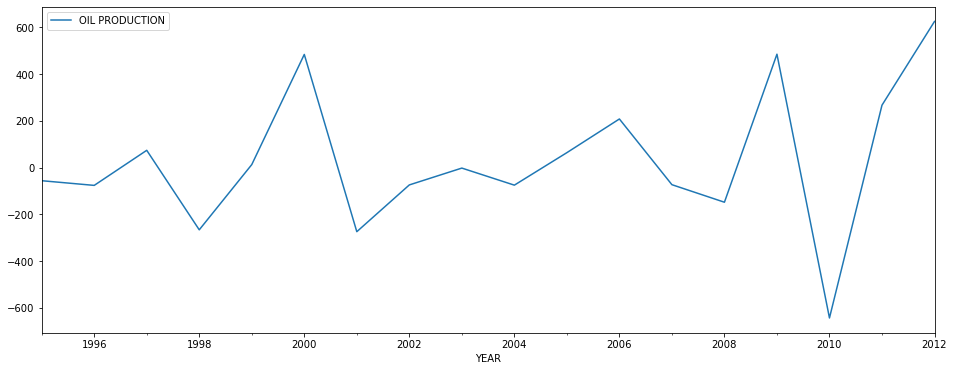

ADF Statistic: -6.191607528895947
p-value: 6.103650224876215e-08


In [17]:
# Taking the 3rd order differencing of the time series
train_data_stationary = train_data.diff().diff().diff().dropna()

# Implementing ADF test on the second order differenced time series data
result = adfuller(train_data_stationary['OIL PRODUCTION'])

fig, ax = plt.subplots(figsize = (16, 6))

train_data_stationary.plot(ax = ax)

plt.show()

# Printing the results

print('ADF Statistic:', result[0])

print('p-value:', result[1])

**Observation:**

- Now, the p-value is less than 0.05, we can say the time series became stationary at d = 3. 

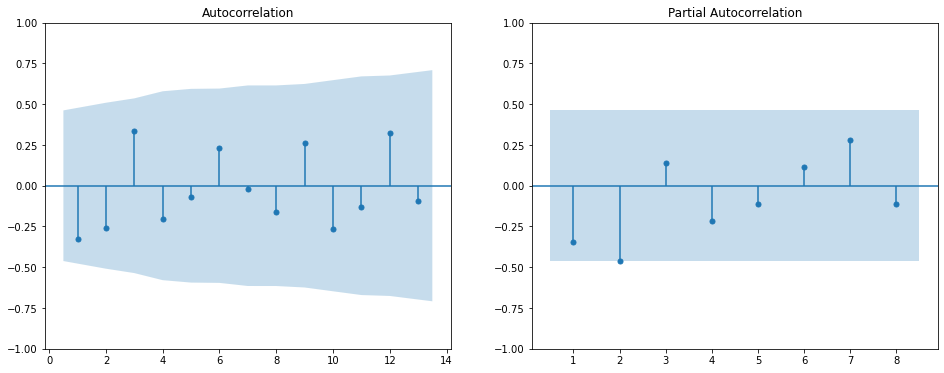

In [18]:
# Creating two subplots to show ACF and PACF plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

# Creating and plotting the ACF charts starting from lag = 1
tsaplots.plot_acf(train_data_stationary, zero = False, ax = ax1)

# Creating and plotting the ACF charts starting from lag = 1 till lag = 8
tsaplots.plot_pacf(train_data_stationary, zero = False, ax = ax2, lags = 8)

plt.show()

**Observation:**

- From the above plots, it does not look like this stationary time series follows a pure AR or MA model. As none of the plots tails off or cuts off after any lag, it implies that the time series follows an ARMA or ARIMA model. 

- The PACF seems to cut off at lag 2, but we cannot be sure because it is too close to the boundary.


**Modelling** 

**Below we will try several different modeling techniques on this time series:**

- AR (p)
- MA (q)
- ARMA (p, q)
- ARIMA (p, d, q)
and then we will check which one performs better.

We will perform hyper-parameter search to find their optimal values for of p, d, and q, 



**AR Modeling**

In [19]:
# We are using the ARIMA function to build the AR model, we will keep the q parameter as 0, so that the model acts as an AR model
# Here, we are building four AR models at lags 1, 2, 3, and 4.

# Creating an AR model with parameter p = 1
ar_1_model = ARIMA(train_data_stationary, order = (1, 0, 0))

# Creating an AR model with parameter p = 2
ar_2_model = ARIMA(train_data_stationary, order = (2, 0, 0))

# Creating an AR model with parameter p = 3
ar_3_model = ARIMA(train_data_stationary, order = (3, 0, 0))

# Creating an AR model with parameter p = 4
ar_4_model = ARIMA(train_data_stationary, order = (4, 0, 0))

In [20]:
# Fitting all the models that we implemented in the above cell

ar_1_results = ar_1_model.fit()

ar_2_results = ar_2_model.fit()

ar_3_results = ar_3_model.fit()

ar_4_results = ar_4_model.fit()

In [21]:
# Function to Inverse Transform forecast after double differencing

def plot_predicted_output(results, ax):
    
    # We are taking double cumulative sum of forecasted values (which is inverse of double differencing)
    # And we are also adding the last element of the training data to the forecasted values to get back to the original scale
    predictions = np.cumsum(np.cumsum(results.predict(start = 19, end = 25))) + train_data.iloc[-1][0]
    
    # Setting indices of the test data into prediction values
    predictions.index = test_data.index
    
    # Computing the AIC and RMSE metrics for the model and printing it into title of the plot
    train_data.plot(ax = ax, label = 'train', 
                    title = 'AIC: {}'.format(np.round(results.aic, 2)) + 
                           ' , ' +
                           'RMSE: {}'.format(np.round(np.sqrt(mean_squared_error(test_data, predictions)), 2)))
    
    # Plotting the test data
    test_data.plot(ax = ax) 
    
    # Plotting the forecasted data
    predictions.plot(ax = ax)
    
    # Adding the legends sequentially
    ax.legend(['train data', 'test data', 'forecasted values'])

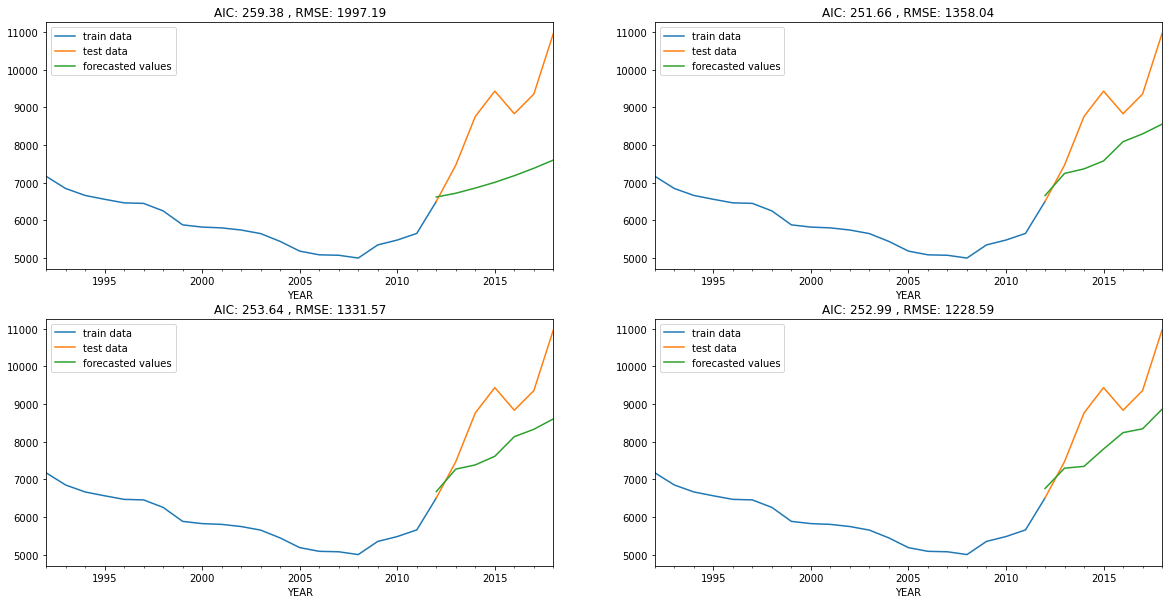

In [22]:
# Plotting the forecasted values along with train and test for all the AR models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ar_1_results, ax1)

plot_predicted_output(ar_2_results, ax2)

plot_predicted_output(ar_3_results, ax3)

plot_predicted_output(ar_4_results, ax4)

plt.show()

**Observation:**

- As we can see from the above results, out of these four AR models, the AIC values for all these models are very much comparable or approximately the same. But if we check the RMSE values, it is the least for AR(4) or ARIMA(4, 0, 0) model, and it is significantly less than the other three models. Based on this analysis, AR(4) or ARIMA(4, 0, 0) looks the best model if we only want to use the AR component while modeling.

In [23]:
# Display summary for the model AR(4).

ar_4_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -120.495
Date:                Tue, 21 Feb 2023   AIC                            252.990
Time:                        22:36:58   BIC                            258.332
Sample:                    01-01-1995   HQIC                           253.727
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0306     17.221      0.466      0.641     -25.722      41.783
ar.L1         -0.8563      0.371     -2.308      0.021      -1.583      -0.129
ar.L2         -1.0208      0.534     -1.911      0.056      -2.067       0.026
ar.L3         -0.3271      0.410     -0.799      0.425      -1.130       0.476
ar.L4         -0.4350      0.340     -1.280      0.201      -1.101       0.231
sigma2      3.249e+04   2.03e+04      1.600      0.110   -7311.527    7.23e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.45   Prob(JB):                         0.83
Heteroskedasticity (H):               2.22   Skew:                             0.10
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**MA Modeling**


In [24]:
# We are using the ARIMA function to build the MA model. We will keep the p parameter as 0 so that the model acts as an MA model

# Creating MA model with parameter q = 1
ma_1_model = ARIMA(train_data_stationary, order = (0, 0, 1))

# Creating MA model with parameter q = 2
ma_2_model = ARIMA(train_data_stationary, order = (0, 0, 2))

# Creating MA model with parameter q = 3
ma_3_model = ARIMA(train_data_stationary, order = (0, 0, 3))

# Creating MA model with parameter q = 4
ma_4_model = ARIMA(train_data_stationary, order = (0, 0, 4))

In [25]:
# Fitting all the models that we implemented in the above cell

ma_1_results = ma_1_model.fit()

ma_2_results = ma_2_model.fit()

ma_3_results = ma_3_model.fit()

ma_4_results = ma_4_model.fit()

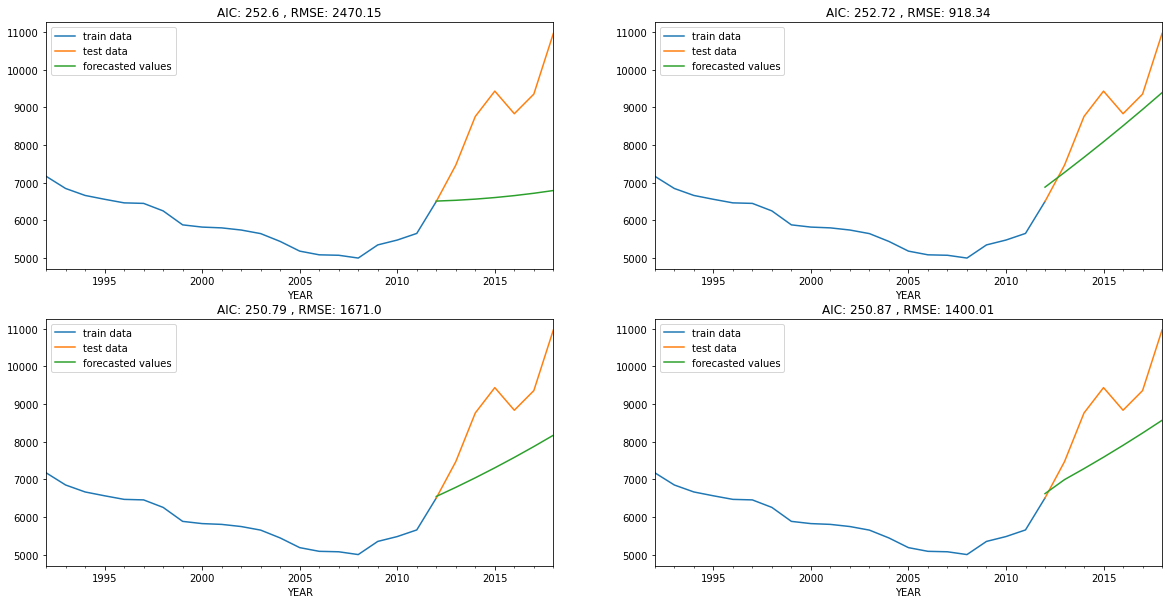

In [26]:
# Plotting the forecasted values along with train and test for all the models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ma_1_results, ax1)

plot_predicted_output(ma_2_results, ax2)

plot_predicted_output(ma_3_results, ax3)

plot_predicted_output(ma_4_results, ax4)

plt.show()

**Observation:**

- As we can see from the above plots, again all the MA models have comparable to AIC, but RMSE is significantly lower for MA(2) model in comparison to all the other models. So, the best model that we have got using MA modeling, is MA(2) or ARIMA(0, 0, 2). This also aligns with our observation that PACF plot seems to cut off at lag 2.

In [27]:
# Display summary for the model MA(2).

ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -122.360
Date:                Tue, 21 Feb 2023   AIC                            252.720
Time:                        22:36:59   BIC                            256.282
Sample:                    01-01-1995   HQIC                           253.211
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8869     12.363      0.881      0.379     -13.344      35.118
ma.L1         -1.7168     34.427     -0.050      0.960     -69.192      65.758
ma.L2          0.9978     39.952      0.025      0.980     -77.307      79.302
sigma2      3.386e+04   1.34e+06      0.025      0.980   -2.59e+06    2.66e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.54   Prob(JB):                         0.66
Heteroskedasticity (H):               1.59   Skew:                             0.51
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**ARMA Modeling**


In [28]:
# We are using the ARIMA function here, with different combinations of p and q parameters keeping d=0

# Creating an ARMA model with parameters p = 2 and q = 1
ar_2_ma_1_model = ARIMA(train_data_stationary, order = (2, 0, 1))

# Creating an ARMA model with parameters p = 2 and q = 2
ar_2_ma_2_model = ARIMA(train_data_stationary, order=(2, 0, 2))

# Creating an ARMA model with parameters p = 3 and q = 2
ar_3_ma_2_model = ARIMA(train_data_stationary, order = (3, 0, 2))

# Creating an ARMA model with parameters p = 2 and q = 3
ar_2_ma_3_model = ARIMA(train_data_stationary, order = (2, 0, 3))

In [29]:
# Fitting all the models that we implemented in the above cell

ar_2_ma_1_results = ar_2_ma_1_model.fit()

ar_2_ma_2_results = ar_2_ma_2_model.fit()

ar_3_ma_2_results = ar_3_ma_2_model.fit()

ar_2_ma_3_results = ar_2_ma_3_model.fit()

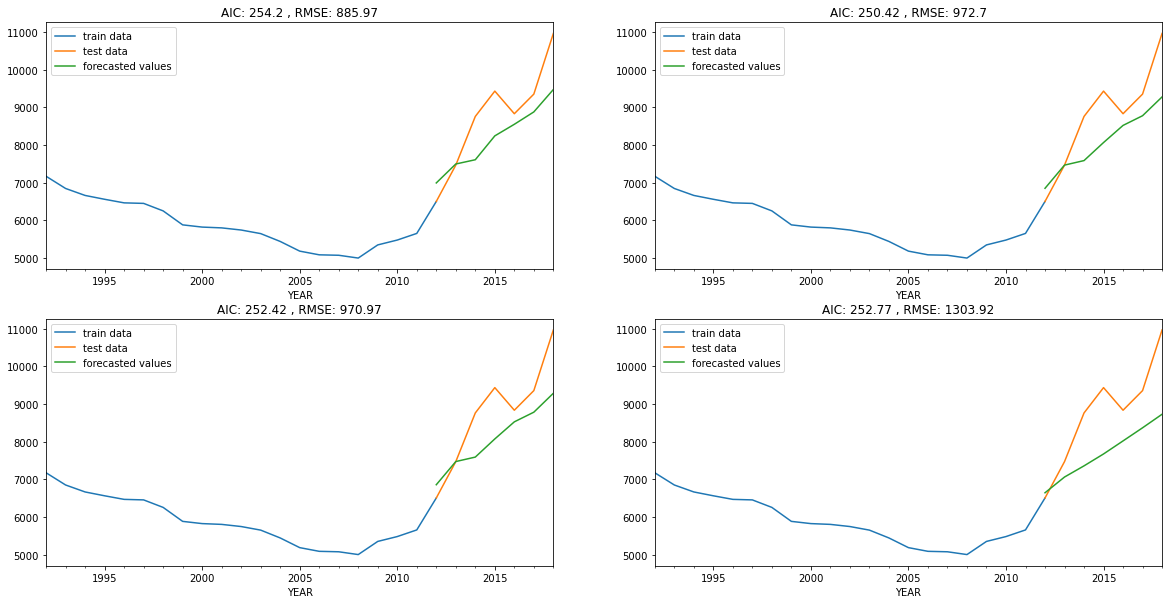

In [30]:
# Plotting the forecasted values along with train and test for all the models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output(ar_2_ma_1_results, ax1)

plot_predicted_output(ar_2_ma_2_results, ax2)

plot_predicted_output(ar_3_ma_2_results, ax3)

plot_predicted_output(ar_2_ma_3_results, ax4)

plt.show()

**Observation:**

- As we can see from the above plots, for ARIMA(2, 0, 1), the RMSE is significantly lower than other models above. 
- Also, it is evident from the above plots that the forecasted values from the model ARIMA(2, 0, 1) are closer to the test data in comparison to all the other models.

In [31]:
# Display summary for the model ARIMA(2, 0, 1).

ar_2_ma_1_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   18
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -122.098
Date:                Tue, 21 Feb 2023   AIC                            254.196
Time:                        22:37:00   BIC                            258.648
Sample:                    01-01-1995   HQIC                           254.810
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5182     35.197      0.242      0.809     -60.466      77.503
ar.L1         -1.2897      0.178     -7.252      0.000      -1.638      -0.941
ar.L2         -0.8177      0.250     -3.269      0.001      -1.308      -0.328
ma.L1          0.9901      3.855      0.257      0.797      -6.566       8.547
sigma2      3.577e+04    1.3e+05      0.275      0.784   -2.19e+05    2.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.23   Prob(JB):                         0.83
Heteroskedasticity (H):               1.75   Skew:                             0.12
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**ARIMA Model**

- We can simply pass the original time without differencing in the ARIMA model, and pass the parameter d = 3, as we already know that after triple differencing the original time series becomes a stationary time series.

In [32]:
train_data = train_data.astype('float32')

In [33]:
# Creating an ARIMA model with parameters p = 2, d = 3 and q = 1
ar_2_d_3_ma_1_model = ARIMA(train_data, order = (2, 3, 1))

# Creating an ARIMA model with parameters p = 1, d = 3 and q = 2
ar_1_d_3_ma_2_model = ARIMA(train_data, order = (1, 3, 2))

# Creating an ARIMA model with parameters p = 2, d = 3 and q = 2
ar_2_d_3_ma_2_model = ARIMA(train_data, order = (2, 3, 2))

# Creating an ARIMA model with parameters p = 3, d = 3 and q = 2
ar_3_d_3_ma_2_model = ARIMA(train_data, order = (3, 3, 2))

In [34]:
# Fitting all the models that we implemented in the above cell

ar_2_d_3_ma_1_results = ar_2_d_3_ma_1_model.fit()

ar_1_d_3_ma_2_results = ar_1_d_3_ma_2_model.fit()

ar_2_d_3_ma_2_results = ar_2_d_3_ma_2_model.fit()

ar_3_d_3_ma_2_results = ar_3_d_3_ma_2_model.fit()

In [35]:
# We need to update the plot_predicted_output() function because the ARIMA model forcast on the original time series so no need to inverse transform forecast.

def plot_predicted_output_new(results, ax):
    
    predictions = results.predict(start = 19, end = 25)
    
    # Setting indices of the test data into prediction values
    predictions.index = test_data.index
    
    # Computing the AIC and RMSE metrics for the model and printing it into title of the plot
    train_data.plot(ax = ax, label = 'train', 
                    
                    title = 'AIC: {}'.format(np.round(results.aic, 2)) + 
                           ' , ' +
                           'RMSE: {}'.format(np.round(np.sqrt(mean_squared_error(test_data, predictions)), 2)))
    
    # Plotting the test data
    test_data.plot(ax = ax) 
    
    # Plotting the forecasted data
    predictions.plot(ax = ax)
    
    # Adding the legends sequentially
    ax.legend(['train data', 'test data', 'forecasted values'])

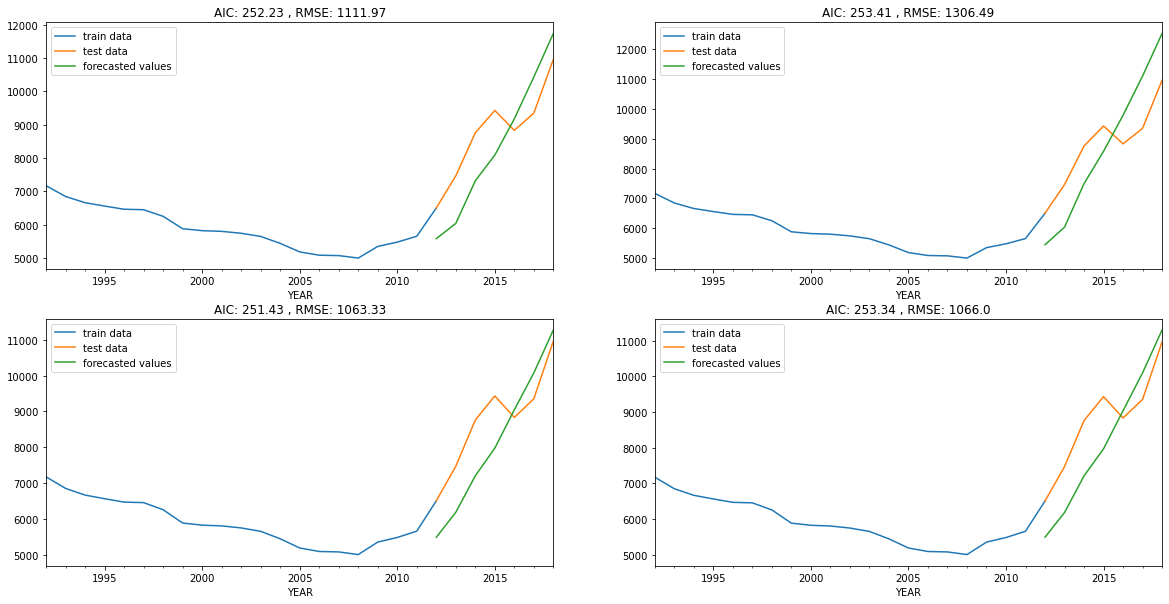

In [36]:
# Plotting the forecasted values along with train and test for all the models

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

plot_predicted_output_new(ar_2_d_3_ma_1_results, ax1)

plot_predicted_output_new(ar_1_d_3_ma_2_results, ax2)

plot_predicted_output_new(ar_2_d_3_ma_2_results, ax3)

plot_predicted_output_new(ar_3_d_3_ma_2_results, ax4)

plt.show()

**Observation:**

- From the above analysis, we can see that the ARIMA(2, 3, 2) is the best model in comparison to others, as it has comparable AIC to other models but less RMSE in comparison to all the other models.

In [37]:
# Display summary for the model ARIMA(2, 3, 2)

ar_2_d_3_ma_2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         OIL PRODUCTION   No. Observations:                   21
Model:                 ARIMA(2, 3, 2)   Log Likelihood                -120.713
Date:                Tue, 21 Feb 2023   AIC                            251.427
Time:                        22:37:01   BIC                            255.879
Sample:                    01-01-1992   HQIC                           252.041
                         - 01-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9701      0.276     -3.518      0.000      -1.511      -0.430
ar.L2         -0.5351      0.318     -1.685      0.092      -1.158       0.087
ma.L1          0.2168      7.403      0.029      0.977     -14.293      14.727
ma.L2         -0.7778      6.047     -0.129      0.898     -12.630      11.074
sigma2      2.577e+04   1.97e+05      0.131      0.896   -3.61e+05    4.12e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.41   Prob(JB):                         0.64
Heteroskedasticity (H):               1.85   Skew:                            -0.10
Prob(H) (two-sided):                  0.47   Kurtosis:                         1.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Observation:**
    
- Overall, the model ARIMA(2, 3, 2) has given the best results and we will use this model to forecast the oil production for United States.

**Lets get the forecasts for country united_states for the next 7 years, i.e., from 2019-01-01 to 2025-01-01 using our best ARIMA model.**

In [38]:
final_model = ARIMA(united_states, order = (2, 3, 2))

final_model_results = final_model.fit()

In [39]:
forecasted_ARIMA = final_model_results.predict(start = '2019-01-01', end = '2025-01-01')

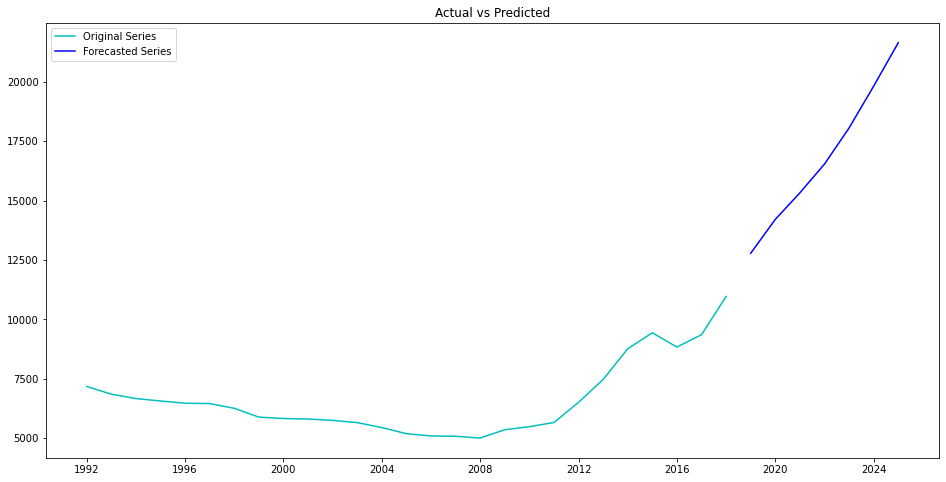

In [40]:
# Plotting the original time seris with forecast

plt.figure(figsize = (16, 8))

plt.plot(united_states, color = 'c', label = 'Original Series')

plt.plot(forecasted_ARIMA, label = 'Forecasted Series', color = 'b')

plt.title('Actual vs Predicted')

plt.legend()

plt.show()

- The above plot shows that the model is able to identify the trend in the data and forecast the values accordingly.
- The forecast indicates that, according to the historic data, the oil production is going to constantly increase for United Sates

**Auto ARIMA**

- Using Auto ARIMA to automatically find the best parameters for our model

In [41]:

import pmdarima as pm

auto_arima_model = pm.auto_arima(train_data, d = 3, seasonal = False, trace = True, 
                                 error_action = 'ignore', suppress_warnings = True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=258.092, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=257.788, Time=0.02 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=252.229, Time=0.02 sec
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=254.063, Time=0.03 sec
 ARIMA(0,3,2)(0,0,0)[0]             : AIC=252.880, Time=0.03 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,3,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,3,1)(0,0,0)[0]          
Total fit time: 0.263 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   21
Model:               SARIMAX(0, 3, 1)   Log Likelihood                -124.115
Date:                Tue, 21 Feb 2023   AIC                            252.229
Time:                        22:37:02   BIC             

**Observation:**
- The auto-arima model is also giving out - ARIMA(0, 3, 1)(0, 0, 0)[0] as the best model.

**Plot and analyze the Auto-ARIMA model diagnostics for residuals

- If the residuals are normally distributed and are uncorrelated to each other, then we actually have a good model.

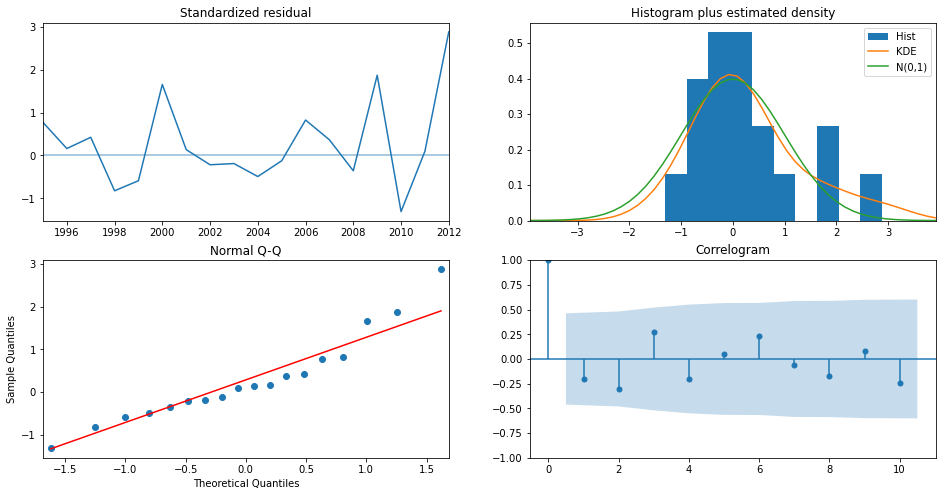

In [42]:
# plot and analyze the model diagnostics for residuals

fig = plt.figure(figsize = (16, 8))

fig = auto_arima_model.plot_diagnostics(fig = fig)

**Observations:**

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a approximately uniform variance.

**Top Right:** The density plot suggests that the distribution of residuals is very close to a standard normal distribution.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution of residuals is skewed.

**Bottom Right:** The ACF plot shows the residual errors are not autocorrelated as no lag other than 0 is significant. Any autocorrelation would imply that there is some pattern in the residual errors that is not explained by the model.

**Our Auto-ARIMA ARIMA(0, 3, 1)(0, 0, 0)[0] model is valid as it satisfies all the conditions above.**